## Performance on training and validation dataset 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from pathlib import Path
import json
import torch
import sys
from typing import Union, List, Dict, Any, Optional
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Paths
PROJECT_DIR = Path.cwd().parent.parent.parent
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

from anglecam import AngleCam

IMAGES_DIR = PROJECT_DIR / "data" / "01_Training_Validation_Data" / "image_data"
DATA_PATH = PROJECT_DIR / "data" / "01_Training_Validation_Data" / "splits"

V01_RESULTS_PATH = PROJECT_DIR / "data" / "03_Model_Outputs" / "predictions" / "training_validation" / "AngleCamV1"
V02_RESULTS_PATH = PROJECT_DIR / "data" / "03_Model_Outputs" / "predictions" / "training_validation" / "AngleCamV2"
FIGURES_PATH = PROJECT_DIR / "data" / "other" / "figures" / "results" 

OUTPUT_DIR = PROJECT_DIR / "data" / "03_Model_Outputs" / "checkpoint"
CHECKPOINT_PATH = OUTPUT_DIR / "AngleCamV2.pth"

# Load data
training_data = pd.read_csv(DATA_PATH / "training.csv", sep=",")
validation_data = pd.read_csv(DATA_PATH / "validation.csv", sep=",")

assert DATA_PATH.exists(), f"Data path not found: {DATA_PATH}"
assert V01_RESULTS_PATH.exists(), f"AngleCam V1 results path not found: {V01_RESULTS_PATH}"
assert V02_RESULTS_PATH.exists(), f"AngleCam V2 results path not found: {V02_RESULTS_PATH}"
assert CHECKPOINT_PATH.exists(), f"Checkpoint path not found: {CHECKPOINT_PATH}"


### AngleCam V2 on training and validation dataset

In [4]:
# Load pretrained model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

config_overrides = {
    "training": {
        "output_dir": "data/model/output" 
    }
}

anglecam = AngleCam.from_checkpoint(
    str(CHECKPOINT_PATH), 
    config_overrides=config_overrides
)
anglecam.device = device

# Move model to selected device for later inference
anglecam.model.to(device)

print("Model loaded and ready for inference.")

Using device: cuda:0


Using cache found in /home/lk1167/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded and ready for inference.


In [3]:
def batch_predict(
    model,
    input_data: Union[str, Path, pd.DataFrame],
    images_dir: Path,
    output_path: Optional[Path] = None,
    batch_size: int = 128,
) -> List[Dict[str, Any]]:
    """
    Batch prediction function.

    Args:
        model: AngleCam model instance with predict() method
        input_data: Either a CSV file path/DataFrame with 'filename' column, or single image path
        images_dir: Directoryd where images are stored (IMAGES_DIR)
        output_path: Optional path to save results as JSON
        batch_size: Number of images to process before clearing GPU cache (default: 32)

    Returns:
        List of prediction results
    """

    def load_labels_robust(labels_filepath: Path) -> tuple:
        """Load labels with automatic separator detection."""
        try:
            # First try with space separator
            labels_df = pd.read_csv(labels_filepath, sep=" ", header=None)
            labels = labels_df.iloc[0, :].to_numpy(dtype=float)
        except (ValueError, TypeError):
            try:
                # If space fails, try comma separator
                labels_df = pd.read_csv(labels_filepath, sep=",", header=None)
                labels = labels_df.iloc[0, :].to_numpy(dtype=float)
            except (ValueError, TypeError):
                try:
                    # Try automatic separator detection
                    labels_df = pd.read_csv(labels_filepath, header=None)
                    labels = labels_df.iloc[0, :].to_numpy(dtype=float)
                except Exception as e:
                    raise ValueError(
                        f"Could not parse labels file with any separator: {e}"
                    )

        # Normalize and calculate mean
        labels = labels / labels.sum()
        labels_mean = np.sum(np.linspace(0, 90, 43) * labels)
        return labels_mean, labels.tolist()

    results = []

    # Handle input data
    if isinstance(input_data, (str, Path)):
        input_path = Path(input_data)
        if input_path.suffix == ".csv":
            df = pd.read_csv(input_path)
            filenames = df["filename"].tolist()
        else:
            filenames = [input_path.name]
    elif isinstance(input_data, pd.DataFrame):
        filenames = input_data["filename"].tolist()
    else:
        raise ValueError(f"Unsupported input type: {type(input_data)}")

    print(f"Processing {len(filenames)} images in batches of {batch_size}")

    # Process in batches
    for i in tqdm(range(0, len(filenames), batch_size), desc="Processing batches"):
        batch_filenames = filenames[i : i + batch_size]

        for filename in batch_filenames:
            try:
                # Image filepath
                image_filepath = images_dir / filename

                if not image_filepath.exists():
                    print(f"Warning: Image not found: {image_filepath}")
                    results.append(
                        {"filename": filename, "error": "Image file not found"}
                    )
                    continue

                # Check if labels exist
                labels_filepath = images_dir / (filename.split(".")[0] + "_sim.csv")
                labels_mean = None
                labels_distribution = None

                if labels_filepath.exists():
                    try:
                        labels_mean, labels_distribution = load_labels_robust(
                            labels_filepath
                        )
                    except Exception as e:
                        print(f"Warning: Could not load labels for {filename}: {e}")

                # Predict the angle
                pred_result = model.predict(image_filepath)

                # Create result dictionary
                result = {
                    "filename": filename,
                    "predicted_mean_leaf_angle": pred_result[
                        "predicted_mean_leaf_angle"
                    ],
                    "predicted_distribution": pred_result["angle_distribution"],
                }

                # Add labels if available
                if labels_mean is not None:
                    result["label_mean_leaf_angle"] = labels_mean
                    result["label_distribution"] = labels_distribution
                    result["prediction_error"] = (
                        pred_result["predicted_mean_leaf_angle"] - labels_mean
                    )
                    result["absolute_error"] = abs(
                        pred_result["predicted_mean_leaf_angle"] - labels_mean
                    )

                results.append(result)

            except Exception as e:
                print(f"Error processing {filename}: {e}")
                error_result = {"filename": filename, "error": str(e)}
                results.append(error_result)

        # Clear GPU cache between batches to manage memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save results if output path provided
    if output_path:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        with open(output_path, "w") as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to {output_path}")

    print(f"Completed processing {len(results)} images")
    return results


# Example usage:
# results = batch_predict(anglecam, training_data, IMAGES_DIR, output_path="results.json")
# results = batch_predict(anglecam, "path/to/filenames.csv", IMAGES_DIR)
# results = batch_predict(anglecam, single_image_path, IMAGES_DIR)

In [ ]:
# Training data
batch_predict(anglecam, training_data, IMAGES_DIR, output_path=V02_RESULTS_PATH / "train_results_anglecam_v2_raw.json")

Processing 3596 images in batches of 128


Processing batches: 100%|██████████| 29/29 [02:33<00:00,  5.31s/it]


Results saved to /mnt/data/lk1167/projects/AngleCamV2/data/paper/results/anglecam_v02/train_results_anglecam_v2.json
Completed processing 3596 images


[{'filename': 'b_346_o2_TLC00015_image_000005.png',
  'predicted_mean_leaf_angle': 40.97870799712837,
  'predicted_distribution': [0.0053978776559233665,
   0.007173452526330948,
   0.009936539456248283,
   0.012852733954787254,
   0.016076549887657166,
   0.018979938700795174,
   0.021089402958750725,
   0.025891151279211044,
   0.02927267737686634,
   0.027788326144218445,
   0.03392723575234413,
   0.03259221091866493,
   0.03445633128285408,
   0.03530655801296234,
   0.03784141689538956,
   0.037687599658966064,
   0.03570932894945145,
   0.038391586393117905,
   0.036147452890872955,
   0.03727973625063896,
   0.038281865417957306,
   0.036740753799676895,
   0.03322455659508705,
   0.03426355868577957,
   0.030460799112915993,
   0.03043927066028118,
   0.029782522469758987,
   0.026585062965750694,
   0.02544599026441574,
   0.021326761692762375,
   0.022149983793497086,
   0.020549576729536057,
   0.01823621429502964,
   0.016210125759243965,
   0.014518813230097294,
   0.0135

In [ ]:
# Validation data
batch_predict(anglecam, validation_data, IMAGES_DIR, output_path=V02_RESULTS_PATH / "validation_results_anglecam_v2_raw.json")

Processing 899 images in batches of 128


Processing batches: 100%|██████████| 8/8 [00:38<00:00,  4.84s/it]


Results saved to /mnt/data/lk1167/projects/AngleCamV2/data/paper/results/anglecam_v02/validation_results_anglecam_v2.json
Completed processing 899 images


[{'filename': 'l_343_o1_TLC00023_image_000011.png',
  'predicted_mean_leaf_angle': 58.64412682588278,
  'predicted_distribution': [0.0013399827294051647,
   0.0015701513038948178,
   0.0022085250820964575,
   0.0025337282568216324,
   0.003726639086380601,
   0.0034984485246241093,
   0.004111466929316521,
   0.00578016834333539,
   0.007791745476424694,
   0.007004552520811558,
   0.010161877609789371,
   0.009209525771439075,
   0.011664288118481636,
   0.013026626780629158,
   0.01539667509496212,
   0.018695781007409096,
   0.01872268319129944,
   0.02158709429204464,
   0.021754136309027672,
   0.026320086792111397,
   0.028983663767576218,
   0.030804309993982315,
   0.029197074472904205,
   0.03351844102144241,
   0.03270946815609932,
   0.03554080054163933,
   0.03692508488893509,
   0.03715219348669052,
   0.038027793169021606,
   0.03555705398321152,
   0.040498413145542145,
   0.04016013443470001,
   0.03915804997086525,
   0.03865377977490425,
   0.03870883584022522,
   0.0

### Plot the results

In [ ]:
# Load the prediction results for AngleCam V2
results_train_path_V2 = V02_RESULTS_PATH / "train_results_anglecam_v2_raw.json"
results_validation_path_V2 = V02_RESULTS_PATH / "validation_results_anglecam_v2_raw.json"

# Load the prediction results for AngleCam V1 (results from the script `manuscript/anglecam_v1/run_predictions.py`)
results_validation_path_V1 = V01_RESULTS_PATH / "validation_results_anglecam_v1_raw.json"

with open(results_train_path_V2) as f1, open(results_validation_path_V2) as f2, open(
    results_validation_path_V1
) as f3:
    train_data = json.load(f1)
    val_data_v2 = json.load(f2)
    val_data_v1 = json.load(f3)

In [7]:
def extract_data_v2(data):
    preds = []
    labels = []
    skipped_count = 0
    
    for item in data:
        try:
            # Check if both prediction and label exist and are valid
            if ("predicted_mean_leaf_angle" in item and 
                "label_mean_leaf_angle" in item and
                item["predicted_mean_leaf_angle"] is not None and
                item["label_mean_leaf_angle"] is not None):
                
                pred_val = float(item["predicted_mean_leaf_angle"])
                label_val = float(item["label_mean_leaf_angle"])
                
                # Additional check for valid values (not NaN or inf)
                if np.isfinite(pred_val) and np.isfinite(label_val):
                    preds.append(pred_val)
                    labels.append(label_val)
                else:
                    skipped_count += 1
                    print(f"Skipped item with invalid values: pred={pred_val}, label={label_val}")
            else:
                skipped_count += 1
                missing_fields = []
                if "predicted_mean_leaf_angle" not in item or item["predicted_mean_leaf_angle"] is None:
                    missing_fields.append("prediction")
                if "label_mean_leaf_angle" not in item or item["label_mean_leaf_angle"] is None:
                    missing_fields.append("label")
                print(f"Skipped item missing: {', '.join(missing_fields)}")
                
        except Exception as e:
            skipped_count += 1
            print(f"Error processing item: {e}")
    
    print(f"Extracted {len(preds)} valid prediction-label pairs, skipped {skipped_count} items")
    return np.array(preds), np.array(labels)


def extract_data_v1(data):
    preds = []
    labels = []
    for item in data:
        preds.append(float(item["predicted_mean_angle"]))
        labels.append(float(item["label_mean_angle"]))
    return np.array(preds), np.array(labels)


train_preds, train_labels = extract_data_v2(train_data)
val_v2_preds, val_v2_labels = extract_data_v2(val_data_v2)

# Extract anglecam v1 results
val_data_v1.keys() if isinstance(val_data_v1, dict) else type(val_data_v1)
val_v1_preds, val_v1_labels = extract_data_v1(val_data_v1["validation_results"])

Skipped item missing: label
Skipped item missing: label
Skipped item missing: label
Skipped item missing: label
Skipped item missing: label
Extracted 3591 valid prediction-label pairs, skipped 5 items
Extracted 899 valid prediction-label pairs, skipped 0 items


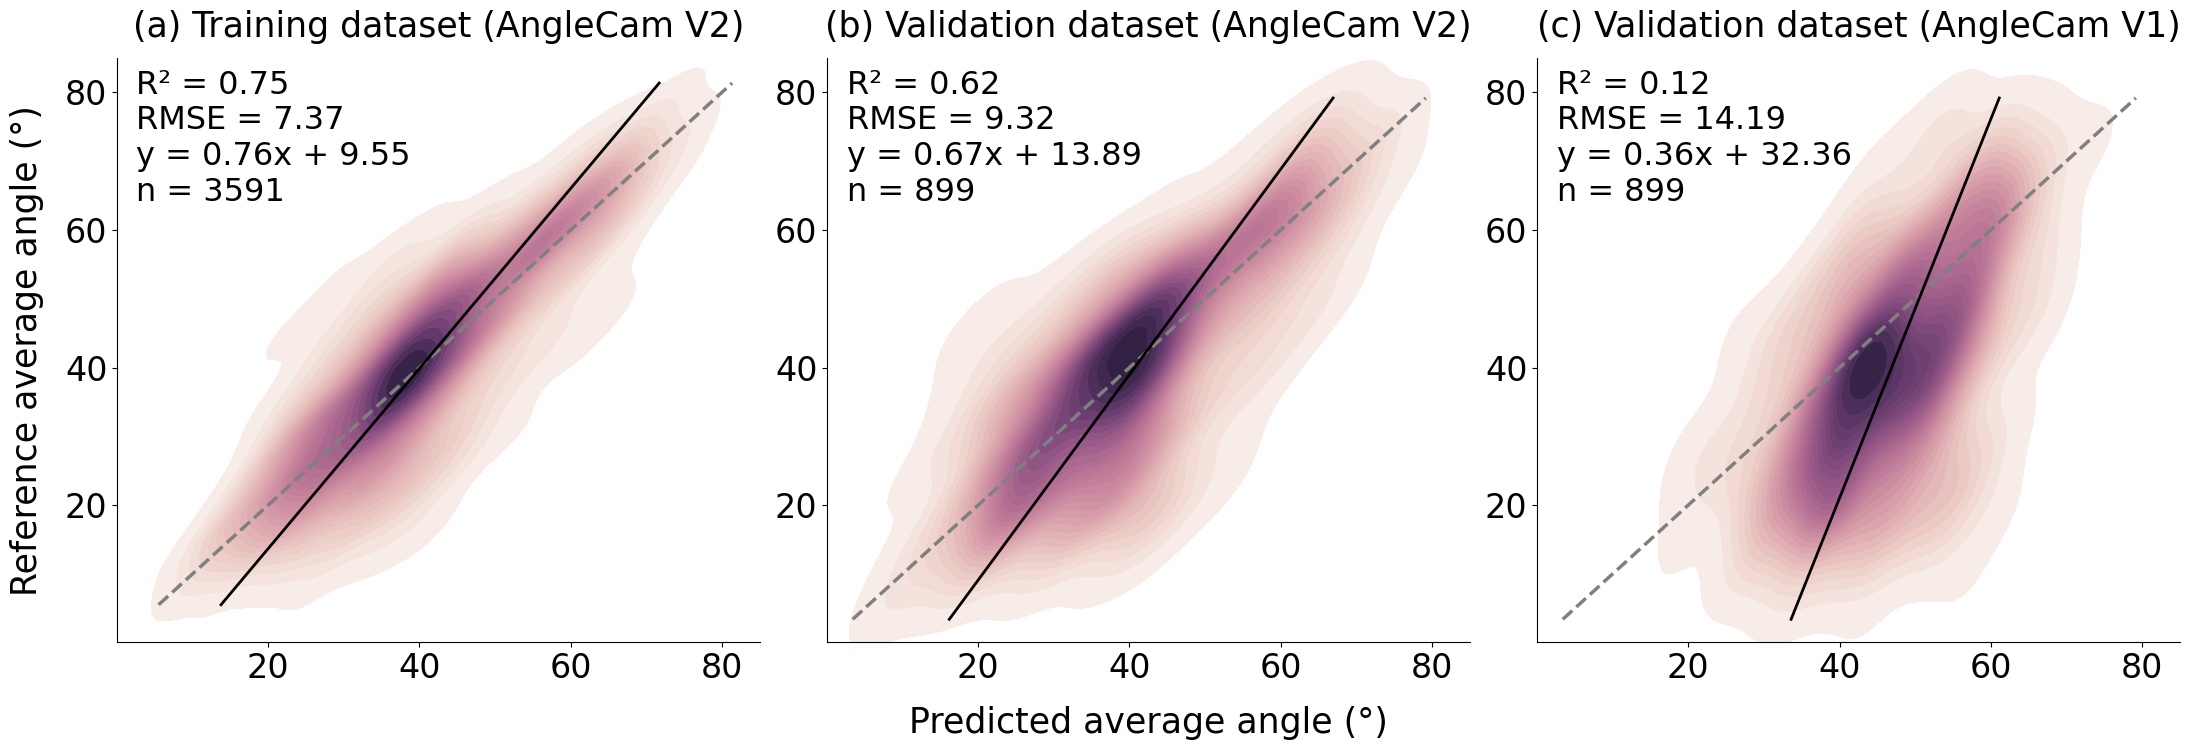

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(22,8))

panels = [
    ("(a)", train_preds, train_labels, "Training dataset (AngleCam V2)"),
    ("(b)", val_v2_preds, val_v2_labels, "Validation dataset (AngleCam V2)"),
    ("(c)", val_v1_preds, val_v1_labels, "Validation dataset (AngleCam V1)"),
]

idx = 0

for ax, (label, preds, labels, title) in zip(axs, panels):
    # Remove all pairs where either preds or labels are zero
    mask = (preds != 0) & (labels != 0)
    preds_clean = preds[mask]
    labels_clean = labels[mask]

    # Plot 2D kernel density estimate
    sns.kdeplot(
        x=preds_clean,
        y=labels_clean,
        ax=ax,
        fill=True,
        cmap=sns.cubehelix_palette(start=0, light=0.95, as_cmap=True),
        thresh=0.01,
        levels=30,
        alpha=1,
    )

    # 1:1 reference line (dashed grey)
    min_val = min(np.min(preds_clean), np.min(labels_clean))
    max_val = max(np.max(preds_clean), np.max(labels_clean))
    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        color="grey",
        linewidth=2.5,
        label="1:1 line",
    )

    # Fit predictions as function of ground truth (labels)
    coef = np.polyfit(labels_clean, preds_clean, 1)
    poly1d_fn = np.poly1d(coef)

    # Sort labels for plotting regression line only where data exists
    sorted_idx = np.argsort(labels_clean)
    sorted_labels = labels_clean[sorted_idx]
    reg_line = poly1d_fn(sorted_labels)
    ax.plot(
        reg_line,
        sorted_labels,
        color="black",
        linewidth=2,
        label=f"Fit: y = {coef[0]:.2f}x + {coef[1]:.2f}",
    )

    # Calculate R2 and RMSE
    r2 = r2_score(labels_clean, preds_clean)
    rmse = np.sqrt(mean_squared_error(labels_clean, preds_clean))

    # Annotate with metrics and fit equation
    textstr = f"R² = {r2:.2f}\nRMSE = {rmse:.2f}\ny = {coef[0]:.2f}x + {coef[1]:.2f}\nn = {len(labels_clean)}"

    ax.text(
        0.03,
        0.98,
        textstr,
        transform=ax.transAxes,
        fontsize=23,
        verticalalignment="top",
        linespacing=1.2,
    )

    ax.set_title(f"{label} {title}", fontsize=25, pad=15)
    if idx == 1:
        ax.set_xlabel("Predicted average angle (°)", fontsize=25, labelpad=15)
    else:
        ax.set_xlabel("")
    if idx == 0:
        ax.set_ylabel("Reference average angle (°)", fontsize=25, labelpad=15)
    else:
        ax.set_ylabel("")

    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(0.05, 85)
    ax.set_ylim(0.05, 85)
    ax.set_xticks([20, 40, 60, 80])
    ax.set_yticks([20, 40, 60, 80])
    ax.tick_params(axis="both", which="major", labelsize=24)
    idx += 1

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save
fig.savefig(
    FIGURES_PATH / "anglecam_v2_v1_regression_panels.png", dpi=400, bbox_inches="tight"
)

plt.show()